In [1]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from pycocotools import mask as mask_utils
from PIL import Image
from torch.utils.data import Dataset
import json

import os


%matplotlib inline

In [2]:
class SA1BDataset(Dataset):
    def __init__(self, img_dir, ann_dir, mask_pixels_present=0.1, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir), key=lambda x: int(x.split('.')[0][3:]))
        self.mask_pixels_present = mask_pixels_present

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)
        img_num_pixels = img.shape[0] * img.shape[1]
        min_mask_pixels = self.mask_pixels_present * img_num_pixels

        ann_path = os.path.join(self.ann_dir, img_name.replace('.jpg', '.json'))
        with open(ann_path, 'r') as f:
            ann_data = json.load(f)

        masks_RLE = []
        crop_boxes = []
        point_coords = []

        ann_data["annotations"] = sorted(ann_data["annotations"], key=lambda x: x["area"], reverse=True)
        for ann in ann_data["annotations"]:
            masks_RLE.append(ann["segmentation"])
            crop_boxes.append(ann["crop_box"])
            point_coords.append(ann["point_coords"])

        masks = mask_utils.decode(masks_RLE)  # [H, W, num_masks]
        masks = masks.transpose(2, 0, 1)  # [num_masks, H, W]
        # 将掩码、裁剪框和点坐标转换为Tensor

        img = torch.from_numpy(img).float()  # [H, W, C]
        masks = torch.from_numpy(masks).float()
        crop_boxes = torch.tensor(crop_boxes).float()  # [X, Y, W, H]
        crop_boxes[:, 2:] += crop_boxes[:, :2]  # 转换为 [X1, Y1, X2, Y2]

        point_coords = torch.tensor(point_coords).float()

        if self.transform:
            img = self.transform(img)

        return img, masks, crop_boxes, point_coords


# 数据转换
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


In [3]:
from torch.utils.data import DataLoader

dataset = SA1BDataset(img_dir='SA-1B/images', ann_dir='SA-1B/annotations')

img, masks, crop_boxes, point_coords = dataset[6]
print(img.shape)
print(masks.shape, crop_boxes.shape, point_coords.shape)




torch.Size([2000, 1500, 3])
torch.Size([104, 2000, 1500]) torch.Size([104, 4]) torch.Size([104, 1, 2])


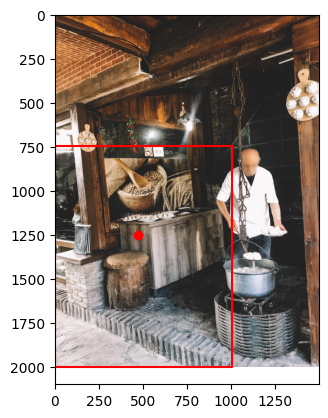

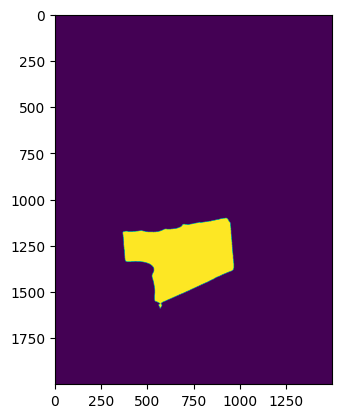

In [4]:
plt.imshow(img.int())
plt.plot([crop_boxes[0][0], crop_boxes[0][2], crop_boxes[0][2], crop_boxes[0][0], crop_boxes[0][0]],
         [crop_boxes[0][1], crop_boxes[0][1], crop_boxes[0][3], crop_boxes[0][3], crop_boxes[0][1]], 'r-')
plt.plot(point_coords[0][0][0], point_coords[0][0][1], 'ro')
plt.show()
plt.imshow(masks[0], )
plt.show()

RuntimeError: Failed to import transformers.models.sam because of the following error (look up to see its traceback):
cannot import name 'is_torch_xla_available' from 'transformers.utils' (/Users/shizhh/anaconda3/envs/eecs127/lib/python3.12/site-packages/transformers/utils/__init__.py)